Using transfer learning to build a CNN to outperform the simple CNN built previously for the dataset of 15 towns / villages in Kent with almost 10,000 images. The purpose of this CNN is to show which towns / cities look the most similar, therefore even though a high accuracy is desirable, a very high accuracy would not have a significant enough number of misclassifications for the analysis.

In [19]:
# Import packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image, ImageOps
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Input, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [4]:
# Desired image size and path
image_size = (224, 224)
dataset_path = "E:/geograph_dataset"

# Create lists for images, city_index, city_name
images = []
labels = []
class_names = []

# Iterate through city folders
for city in sorted(os.listdir(dataset_path)):
    city_path = os.path.join(dataset_path, city)
    if not os.path.isdir(city_path):
        continue
    if city not in class_names:
        class_names.append(city)
    # Iterate through region sub-folders
    for region in os.listdir(city_path):
        region_path = os.path.join(city_path, region)
        if not os.path.isdir(region_path):
            continue
        # Pad and label images based on city
        for image_file in glob.glob(os.path.join(region_path, "*.jpg")):
            img = Image.open(image_file).convert("RGB")
            img = ImageOps.pad(img, image_size, method=Image.BICUBIC, color=(0, 0, 0))
            images.append(np.array(img))
            labels.append(class_names.index(city))

# Set lists to arrays
images = np.array(images)
labels = np.array(labels)
num_classes = len(class_names)

In [5]:
# Train / temp split (80/20)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=349)

# Temp split into val / test (50/50 of 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=349)

# One-hot encoded labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [6]:
# Applies random augmentations each epoch
train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input  # EfficientNet preprocessing (Required for EfficientNet to work)
)

# 'Augmentation' is just standardisation
val_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generates batches
train_data = train_aug.flow(X_train, y_train_cat, batch_size=32, shuffle=True)
val_data = val_aug.flow(X_val, y_val_cat, batch_size=32)
test_data = val_aug.flow(X_test, y_test_cat, batch_size=32, shuffle=False)

In [7]:
def build_effnet(input_shape, num_classes):
    base = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base.trainable = False  # Freeze for transfer learning

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(base.input, output)
    return model

In [12]:
def train_model(model, name, train_data, val_data, learning_rate=1e-2, epochs=50):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-7)
    checkpoint_cb = ModelCheckpoint(
        filepath=f"{name}_checkpoint.ckpt",  # Save the model checkpoints
        save_weights_only=True,
        save_best_only=True,  # Only save the best model
        verbose=1
    )
    #Enables loading from a checkpoint if multiple sessions are required
    if os.path.exists(f"{name}_checkpoint.ckpt.index"):
        print(f"Loading model weights from {name}_checkpoint.ckpt...")
        model.load_weights(f"{name}_checkpoint.ckpt")
    history = model.fit(
        train_data, 
        validation_data=val_data, 
        epochs=epochs, 
        callbacks=[early_stop, lr_scheduler, checkpoint_cb], 
        verbose=2
    )
    model.save(f"{name}.keras")    
    return history, model

In [13]:
def save_history_to_csv(history, filename):
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(filename, index=False)

In [14]:
input_shape = (224, 224, 3)

# Build and train with a frozen base
effnet = build_effnet(input_shape, num_classes)
history_effnet, model_effnet = train_model(effnet, "effnet_frozen", train_data, val_data, learning_rate=1e-2)
save_history_to_csv(history_effnet, "history_effnet.csv")

Epoch 1/50

Epoch 1: val_loss improved from inf to 2.44242, saving model to effnet_frozen_checkpoint.ckpt
241/241 - 376s - loss: 2.6690 - accuracy: 0.1290 - val_loss: 2.4424 - val_accuracy: 0.2058 - lr: 0.0100 - 376s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_loss did not improve from 2.44242
241/241 - 337s - loss: 2.5734 - accuracy: 0.1458 - val_loss: 2.4476 - val_accuracy: 0.1757 - lr: 0.0100 - 337s/epoch - 1s/step
Epoch 3/50

Epoch 3: val_loss improved from 2.44242 to 2.42760, saving model to effnet_frozen_checkpoint.ckpt
241/241 - 167s - loss: 2.5512 - accuracy: 0.1505 - val_loss: 2.4276 - val_accuracy: 0.2193 - lr: 0.0100 - 167s/epoch - 692ms/step
Epoch 4/50

Epoch 4: val_loss improved from 2.42760 to 2.36100, saving model to effnet_frozen_checkpoint.ckpt
241/241 - 167s - loss: 2.5241 - accuracy: 0.1598 - val_loss: 2.3610 - val_accuracy: 0.2297 - lr: 0.0100 - 167s/epoch - 692ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 2.36100
241/241 - 167s - loss: 2.5203 - accuracy: 

NameError: name 'pd' is not defined

In [21]:
#Load the previous model
model_effnet_7 = load_model("effnet_frozen.keras")
print(f"Total layers in model: {len(model_effnet_7.layers)}")

# Unfreeze block7
for layer in model_effnet_7.layers:
    if "block7" in layer.name:
        layer.trainable = True
# Build and train with block7 unfrozen
history_7, model_7 = train_model(model_effnet_7, "effnet_unfrozen_block7", train_data, val_data, learning_rate=1e-5)
save_history_to_csv(history_7, "history_7.csv")

#Load the previous model
model_effnet_6 = load_model("effnet_unfrozen_block7.keras")

#Unfreeze block7 and block6
for layer in model_effnet_6.layers:
    if "block7" in layer.name or "block6" in layer.name:
        layer.trainable = True
# Build and train with block7 and block6 unfrozen
history_6, model_6 = train_model(model_effnet_6, "effnet_unfrozen_block6", train_data, val_data, learning_rate=1e-6)
save_history_to_csv(history_6, "history_6.csv")

Total layers in model: 242
Epoch 1/50

Epoch 1: val_loss improved from inf to 2.79494, saving model to effnet_unfrozen_block7_checkpoint.ckpt
241/241 - 195s - loss: 5.4369 - accuracy: 0.1600 - val_loss: 2.7949 - val_accuracy: 0.2256 - lr: 1.0000e-05 - 195s/epoch - 809ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.79494 to 2.60326, saving model to effnet_unfrozen_block7_checkpoint.ckpt
241/241 - 183s - loss: 3.1849 - accuracy: 0.1800 - val_loss: 2.6033 - val_accuracy: 0.2318 - lr: 1.0000e-05 - 183s/epoch - 758ms/step
Epoch 3/50

Epoch 3: val_loss improved from 2.60326 to 2.47903, saving model to effnet_unfrozen_block7_checkpoint.ckpt
241/241 - 180s - loss: 2.7138 - accuracy: 0.1918 - val_loss: 2.4790 - val_accuracy: 0.2370 - lr: 1.0000e-05 - 180s/epoch - 746ms/step
Epoch 4/50

Epoch 4: val_loss improved from 2.47903 to 2.42275, saving model to effnet_unfrozen_block7_checkpoint.ckpt
241/241 - 179s - loss: 2.5668 - accuracy: 0.1876 - val_loss: 2.4228 - val_accuracy: 0.2474 - lr: 1.

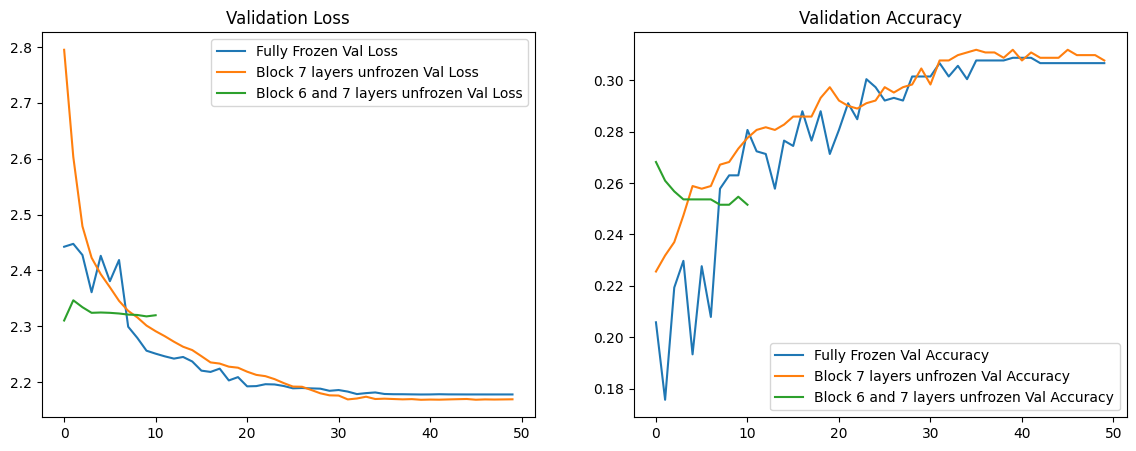

In [22]:
def plot_history(histories, names):
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    for hist, name in zip(histories, names):
        plt.plot(hist.history['val_loss'], label=f'{name} Val Loss')
    plt.title('Validation Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    for hist, name in zip(histories, names):
        plt.plot(hist.history['val_accuracy'], label=f'{name} Val Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.show()

plot_history([history_effnet, history_7, history_6], ['Fully Frozen', 'Block 7 layers unfrozen', 'Block 6 and 7 layers unfrozen'])

It can be seen that each successive model began with a higher validation accuracy. Both the Fully Frozen CNN and the block 7 unfrozen CNN managed to reach comparable accuracies while the block 6 and 7 unfrozen CNN struggled to improve. This is similarly true with when looking at validation loss over time with both the Fully Frozen CNN and the block 7 unfrozen CNN achieving similar maximums with the block 7 unfrozen CNN barely edging out like it did with validation accuracy. Similarly the block 6 and 7 unfrozen CNN struggled to improve from its initial validation loss, using less epochs of training and having the highest validation loss and lowest validation accuracy after training.

31/31 [==============================] - 20s 604ms/step

Fully Frozen EffNet Classification Report:

                       precision    recall  f1-score   support

              ashford       0.40      0.38      0.39        63
           canterbury       0.35      0.35      0.35        72
             dartford       0.38      0.05      0.09        60
                dover       0.47      0.47      0.47        75
            gravesend       0.20      0.25      0.22        64
            maidstone       0.30      0.06      0.09        54
              margate       0.33      0.22      0.26        60
       medway_chatham       0.13      0.27      0.18        56
    medway_gillingham       0.15      0.20      0.18        69
       medway_rainham       0.42      0.37      0.39        52
     medway_rochester       0.15      0.15      0.15        71
royal_tunbridge_wells       0.44      0.45      0.45        75
            sevenoaks       0.20      0.38      0.26        66
        sittingb

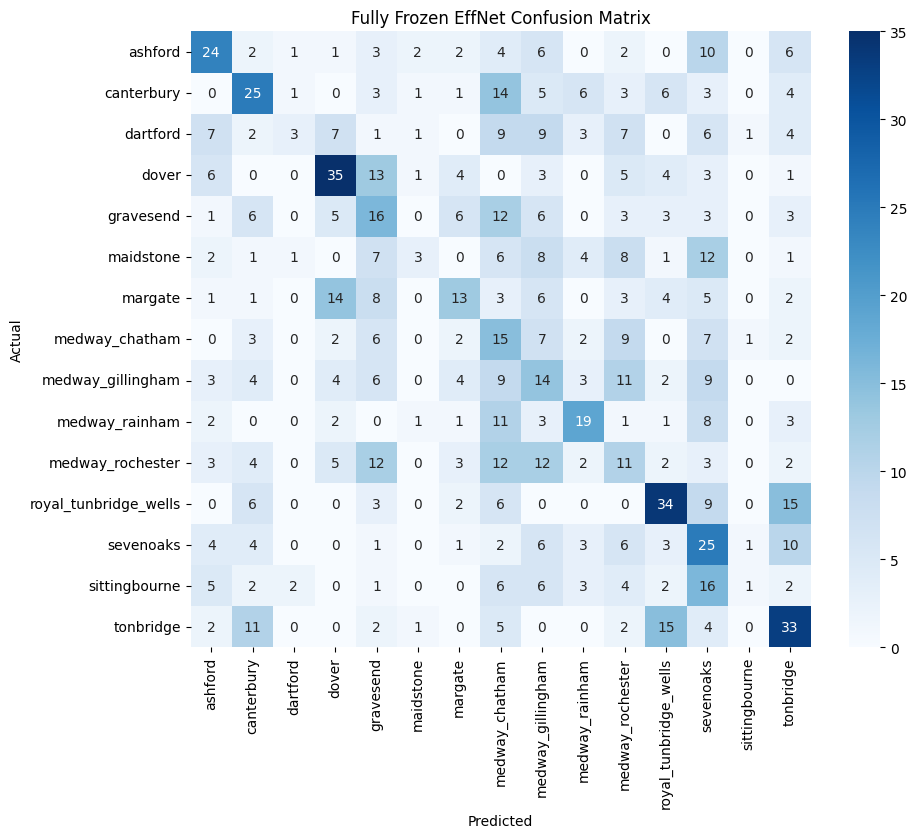

31/31 [==============================] - 20s 590ms/step

Block 7 layers EffNet Classification Report:

                       precision    recall  f1-score   support

              ashford       0.40      0.40      0.40        63
           canterbury       0.38      0.32      0.35        72
             dartford       0.38      0.08      0.14        60
                dover       0.44      0.45      0.44        75
            gravesend       0.16      0.20      0.18        64
            maidstone       0.39      0.13      0.19        54
              margate       0.38      0.28      0.32        60
       medway_chatham       0.15      0.25      0.19        56
    medway_gillingham       0.13      0.10      0.11        69
       medway_rainham       0.47      0.38      0.42        52
     medway_rochester       0.19      0.15      0.17        71
royal_tunbridge_wells       0.44      0.48      0.46        75
            sevenoaks       0.18      0.38      0.24        66
        sittin

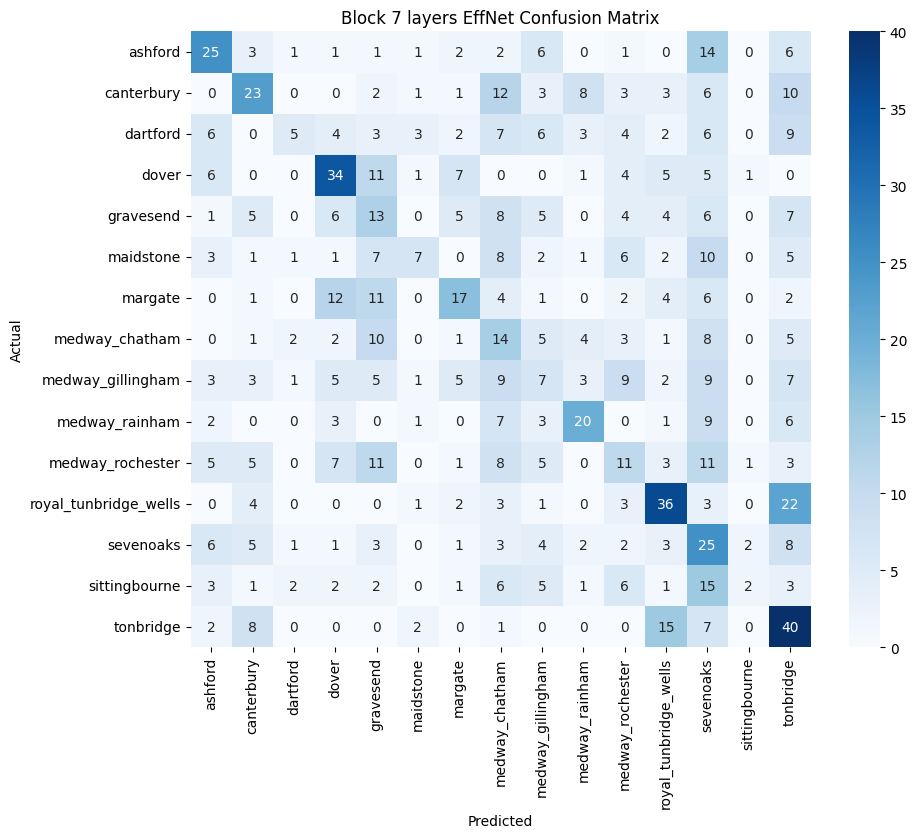

31/31 [==============================] - 20s 595ms/step

Block 6 and 7 layers EffNet Classification Report:

                       precision    recall  f1-score   support

              ashford       0.37      0.37      0.37        63
           canterbury       0.36      0.26      0.30        72
             dartford       0.28      0.12      0.16        60
                dover       0.36      0.51      0.42        75
            gravesend       0.16      0.16      0.16        64
            maidstone       0.28      0.13      0.18        54
              margate       0.29      0.23      0.26        60
       medway_chatham       0.12      0.12      0.12        56
    medway_gillingham       0.23      0.23      0.23        69
       medway_rainham       0.32      0.38      0.35        52
     medway_rochester       0.15      0.18      0.16        71
royal_tunbridge_wells       0.35      0.31      0.33        75
            sevenoaks       0.19      0.41      0.26        66
        

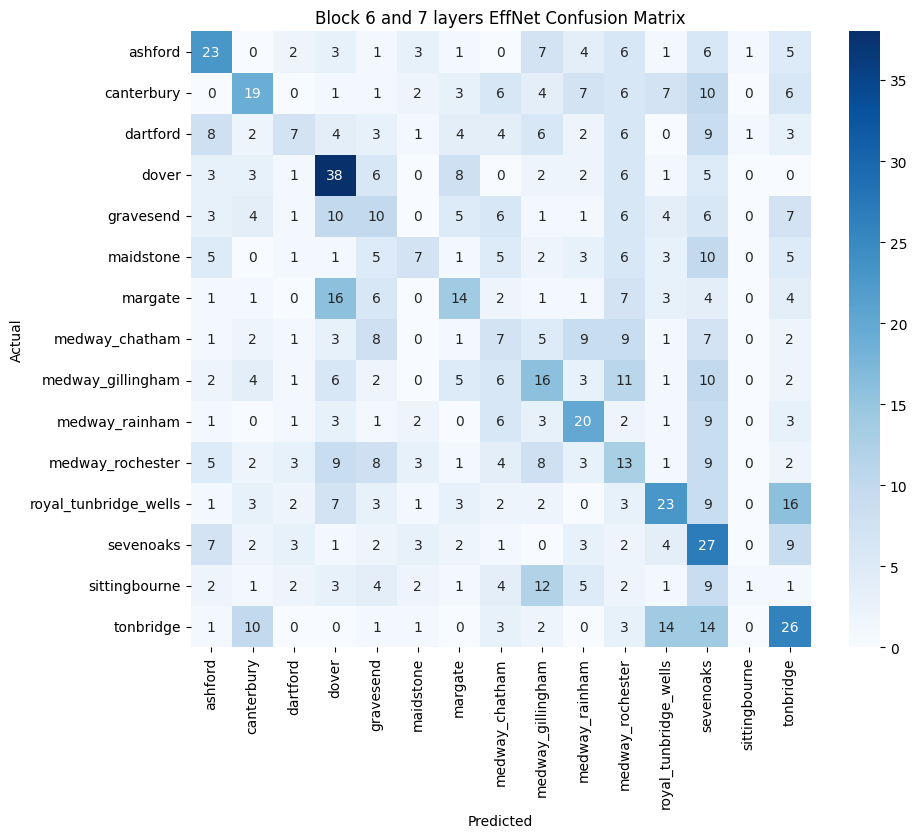

In [23]:
def evaluate_model(model, name):
    # Get model predictions
    preds = model.predict(test_data)
    
    # Get predicted class labels
    pred_classes = np.argmax(preds, axis=1)
    
    # Convert one-hot encoded true labels to class labels
    true_classes = np.argmax(y_test_cat, axis=1)

    print(f"\n{name} Classification Report:\n")
    # Use zero_division=0 to handle cases where precision/recall is undefined
    print(classification_report(true_classes, pred_classes, target_names=class_names, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(true_classes, pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(model_effnet, "Fully Frozen EffNet")
evaluate_model(model_7, "Block 7 layers EffNet")
evaluate_model(model_6, "Block 6 and 7 layers EffNet")

The CNN where block 7 and not block 6 layers were unfrozen performed the best achieving the best precision, recall, and f1 scores. It had a 31% accuracy on thr validation set, and 29% on the test set making it >4x better than random guessing. Tonbridge, Royal Tunbridge Wells and Dover consitently had the highest recall with Rainham, Ashford and Canterbury having comparable f1 scores due to high precision. One clear misclassification pair from the matrices are Tonbridge and Royal Tunbridge Wells; given their similar geography, and sharing period specific housing this is unsurprising. Sittingbourne had particularly bad precision and recall with very few predictions made of the town. This is likely due to it looking very similar to other towns with few distinct features, and being the smallest dataset. Seavonoaks appears to have the opposite problem of being overpredicted, this could be due to it being a larger dataset, and potentially the largest of the less distinct towns which might also include Ashford, Maidstone and Dartford. The size and layout of homes tend to be different in these five towns so, more data and a more even distribution of data might help a CNN improve in classifying these towns. Noteably, these are the smallest datasets (excluding the Medway towns which are distinct and more similar to eachother).

In [34]:
def evaluate_misclassifications(model, name):
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix

    # Get model predictions
    preds = model.predict(test_data)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(y_test_cat, axis=1)

    # Confusion matrix and class sizes
    cm = confusion_matrix(true_classes, pred_classes)
    class_sizes = np.bincount(true_classes)

    # Misclassification dictionary
    misclassified_as = []

    # For each class pair, calculate misclassification percentages
    for i in range(len(class_sizes)):
        for j in range(i + 1, len(class_sizes)):  # Only consider unique class pairs
            mis_i_as_j = cm[i, j] / class_sizes[i] * 100 if class_sizes[i] > 0 else 0
            mis_j_as_i = cm[j, i] / class_sizes[j] * 100 if class_sizes[j] > 0 else 0

            # Store the misclassifications
            misclassified_as.append({
                'Class 1': class_names[i],
                'Class 2': class_names[j],
                'C1 -> C2': mis_i_as_j,
                'C2 -> C1': mis_j_as_i,
                'Combined': (mis_i_as_j * class_sizes[i] + mis_j_as_i * class_sizes[j]) / (class_sizes[i] + class_sizes[j])
            })
            
    # Convert to Pandas DataFrame
    df = pd.DataFrame(misclassified_as)

    # Top 10 combined misclassifications
    top_combined = df.sort_values(by='Combined', ascending=False).head(10)
    print(f"\n{name} Top 10 Most Common Misclassifications (Combined):")
    print(top_combined[['Class 1', 'Class 2', 'C1 -> C2', 'C2 -> C1', 'Combined']])

    # Top 10 single-directional misclassifications
    one_way_rows = []
    for _, row in df.iterrows():
        if row['C1 -> C2'] > row['C2 -> C1']:
            one_way_rows.append({
                'Actual': row['Class 1'],
                'Prediction': row['Class 2'],
                'Misclassification (%)': row['C1 -> C2']
            })
        else:
            one_way_rows.append({
                'Actual': row['Class 2'],
                'Prediction': row['Class 1'],
                'Misclassification (%)': row['C2 -> C1']
            })

    # Convert to Pandas DataFrame
    one_way_df = pd.DataFrame(one_way_rows)
    top_one_way = one_way_df.sort_values(by='Misclassification (%)', ascending=False).head(10)

    print(f"\n{name} Top 10 Highest One-Way Misclassifications:")
    print(top_one_way)

evaluate_misclassifications(model_effnet, "Fully Frozen EffNet")
evaluate_misclassifications(model_7, "Block 7 layers EffNet")
evaluate_misclassifications(model_6, "Block 6 and 7 layers EffNet")

31/31 [==============================] - 51s 2s/step

Fully Frozen EffNet Top 10 Most Common Misclassifications (Combined):
                   Class 1            Class 2   C1 -> C2   C2 -> C1   Combined
101  royal_tunbridge_wells          tonbridge  20.000000  20.000000  20.000000
79          medway_chatham   medway_rochester  16.071429  16.901408  16.535433
85       medway_gillingham   medway_rochester  15.942029  16.901408  16.428571
52               gravesend     medway_chatham  18.750000  10.714286  15.000000
102              sevenoaks      sittingbourne   1.515152  32.000000  14.655172
41                   dover            margate   5.333333  23.333333  13.333333
19              canterbury     medway_chatham  19.444444   5.357143  13.281250
39                   dover          gravesend  17.333333   7.812500  12.949640
77          medway_chatham  medway_gillingham  12.500000  13.043478  12.800000
78          medway_chatham     medway_rainham   3.571429  21.153846  12.037037

Fully 

It was expected that Royal tunbridge wells and Tonbridge would be two of the most similar towns to eachother and this is displayed in the models since despite their relatively high f1 scores (0.46 and 0.38 in the "best model") they combine to be missclassifed as eachother at least 20% of the time (Almost 25% in the "best" model). In addition they consitently topped the combined misclassifications table. Some other expected common misclassifications were the four Medway towns with eachother as they merge into eachother and Dover with Margate as they are distinctly more coastal than the other towns. These assumptions do appear correct with Medway towns frequently appearing in the top ten one-way and combined classifications with one another and Margate frequently being misclassified as Dover (>20%). 